# Summary of Findings


### Introduction
The house stock watcher API give us a full dataset of congress stock disclosures, which are mandated by the Federal Government. In project 3, we cleaned, explored, and tested this database, asking the question:
Is there a difference in trading behavior between political parties?
Our hypothesis test alluded to the fact that Republicans trade more money than Democrats. 

In this project, we will continue this analysis and build a prediction model that will answer the following question:

Is is it possible to predict whether a representative is democratic or republican from their stock trades?

Since we are predicting Democratic and Republican, this is a classification problem. As such, our target variable will be the Party Affiliation column we added in the last project.

In this project, since we are predicting Republican vs Democrat, we aren't necessarily trying to maximize either precision or recall, because we don't prefer false positives over false negatives, or vice versa. 

Thus, a good evaluation metric for this instance would be the f1 score, which uses the harmonic mean of precision and recall. Although our data is imbalanced to a certain extent, let's also keep an eye on accuracy. 

### Baseline Model
For the Baseline Model, I wanted to choose interesting features that didn't require too much feature engineering so that I could further expand on them in the final model.

I began with three features that seemed like the may have had some significance: District(Nominal), Type(Nominal), and amount(Ordinal)

According to the sklearn documentation, for this kind of classification problem, you should first try LinearSVC classification model, so I chose that as my first model. 

Upon running the model, I was immediately given test accuracy of 0.98, and a f1_score of 0.998. (See Below)

How is this possible? Had we already found the best model for this question?

Unfortunately, even with a train accuracy of 0.99 and a test accuracy of 0.98, there had to be some underlying reason that the model was giving such a high result 

Looking at the district column tells us the whole story. The stock data that we have only goes back about two years, to January 2020. Thus, in the stock trades that have happened in that time, the representatives have most probably not changed office, and thus certain districts will always either be republican or democratic. The model was memorizing this information, and whenever we gave it a district from the test set, it knew what political party they were in because it had never seen the other party in these districts. If we had a lot more data, with many years of information, district would be more useful.

Since I couldn't use district in it's current state, I decided to save it for further engineering in the final model. 

After taking away the district, my baseline model was left with two features: type(Nominal) and amount(Ordinal)

The model gave training accuracy of 0.69699 and a testing accuracy of 0.69696, along with a f1 score of 0.401.
Although this model is in no way at it's max effectiveness yet, it is more in line with what we expected to see at this stage. 

We know that republicans make up 1/3 of this dataset, with the rest being democrats. The accuracy also lines up closely with 70%, so there is a chance that this dataset is almost always guessing democrat, and only getting the republicans wrong, which still gets it an accuracy of around 70%. This is why it's also important to look at our main statistic, the f1 score, which in this case is quite low, at 0.4. We will work on raising this score in the final model.

### Final Model
For the final model, we want to focus on raising the f1 score.
I first needed to assess my choice of model. So far, I had used LinearSVC to conduct my predictions, and while it was predicting with relatively high accuracy, I wanted a model that would increase my f1 score as well. Thus, I consulted the sklearn documentation which reccomends using KNeighbors after LinearSVC. I also like KNeighbors because it doesn't assume anything about the data. 

During our EDA in Project 03, we found that there may be a correlation between the month of the trade and the political party, so I wanted to use month in the final model as a nominal, one-hot encoded feature. We also saw in the last project that certain parties tend to prefer certain stocks and sectors, so I though ticker may be helpful as well 
Since both of these features contained NaNs, I had to do some quick data cleaning.
Instead of the string, "amount" column, I decided to use the "amounts(lower estimate)" column of ints, as a ordinally encoded feature. I was also curious whether the "title" of the representatives could play a role in determining Political Party, and so engineered a feature that found the title(nominal) and one-hot encoded it.

It was now time to tackle the problem of the districts. On the surface, using the distance seems like a good idea becuase the district a representative is from can truly be a great predictor of their affiliation. However, because of the limited data we have, there's no way of using districts without the model memorizing them. Thus, I figured that if we generalized a bit, we may be able to engineer a feature that is more robust to memorization.
I decided to make a new feature, called states. This would grab the name of the state from each district and onehot encode them.

Upon seeing the results of the model, we got a very good test accuracy and f1 score, 0.98 and 0.97 respectively. However, I was still suspicous, and explored the data further to see that the state feature would also be heavily biased. Thus, I decided that the best idea would be to not use the district column altogether.

This brought me to a total of 5 features for my final model.

The results of my model from using the rest of the features:

Training accuracy: 0.95

Testing accuracy: 0.89

f1-score = 0.83

While the model is slighty overfit, it is still able to predict party affiliations with a high degree of accuracy, and we see a major improvement in f1 score. 

I then cross-validated my model using grid search and the parameters n_neighbors and tree_nodes. The grid search returned a value of 1 for both. 

### Fairness Evaluation
I lastly needed to asses my model for fairness. Looking at the distribution of the dataset, the amounts(lower estimate), there are far more values under 15000 than over 15000, at a 3:1 ratio. I wanted to make sure that the model was fair, and wasn't unfairly assuming the party based on the amount they traded.

I decided that I would split my data based on the amount of money of the trade, to answer the question:

Does my model fairly predict based on amount of money traded?

I split my data, with one table with amounts <= 15000, and the other with amounts > 15000

My hypothesis were as follows:

    Null: my model is fair; the precision of the two tables are roughly the same
    
    Alternative: my model is unfair; the precision for the amounts(less than 15000) is higher than the precision for the (amounts greater than 15000)

For this permutation test, I decided to use the difference of precisions between amounts <= 15000 and amounts > 15000. My observed statistic was -0.059, which meant that there was a 5 percent difference in precisions between the two in the observed set.
After running the permutation test, I recieved a P-value of 0.05 which meant that this difference in precision was only randomly possible 5% of the time. Thus, I must reject my null hypothesis which alludes to the fact that there is bias in my model based on amount of money traded.

# Code

In [823]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import requests
import json
import warnings
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
#warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [899]:
response = requests.get('https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json')
stocks = pd.read_json(response.content)

In [900]:
#Use same cleaning as project 3
#clean() function is at the bottom of the project
stocks = clean(stocks)

In [901]:
stocks.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,full_name,Party Affiliation,month,amounts(lower estimate)
0,2021.0,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,republican,9.0,1001
1,2021.0,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,republican,9.0,1001
2,2021.0,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,republican,9.0,1001
3,2021.0,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,republican,9.0,1001
4,2021.0,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,republican,9.0,15001


# Baseline Model

For the Baseline Model, I wanted to choose interesting features that didn't require too much feature engineering so that I could further expand on them in the final model.

I began with three features that seemed like the may have had some significance: District(Nominal), Type(Nominal), and amount(Ordinal)

In [358]:
#Create relevant dataframes
X = stocks.loc[:, {'type', 'amount', 'district'}]
y = stocks['Party Affiliation'].replace({'republican' : 1, 'democrat' : 0})
#Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [388]:
#Baseline model
#district was used at first, and then removed
nominal = ['type']#,district
nominal_transformer = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore'))
])
ordinal = ['amount']
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])
preproc = ColumnTransformer(
    transformers = [
        ('nominal', nominal_transformer, nominal),
        ('ordinal', ordinal_transformer, ordinal)
    ]
)
model = Pipeline(steps=[
    ('preprocessor', preproc),
    ('clf', LinearSVC())
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'district']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['amount'])])),
                ('clf', LinearSVC())])

### First model

Upon using the district column, I was met with an extremely high testing and training accuracy, and a very high f score. Looking at the confusion matrix showed me that I only got 6 wrong. How was this even possible?

The stock data that we have only goes back about two years, to January 2020. Thus, in the stock trades that have happened in that time, the representatives have most probably not changed office, and thus certain districts will always either be republican or democratic. The model was memorizing this information, and whenever we gave it a district from the test set, it knew what political party they were in because it had never seen the other party in these districts. If we had a lot more data, with many years of information, district would be more useful.

In [373]:
#Training accuracy
model.score(X_train, y_train)

0.9995289684408856

In [374]:
#Test accuracy
model.score(X_test, y_test)

0.999057936881771

In [375]:
pred = model.predict(X_test)

In [376]:
#f1_score
f1_score(y_test, pred)

0.9986382206082615

In [377]:
#Confusion Matrix
confusion_matrix(y_test, pred)

array([[4163,    6],
       [   0, 2200]])

### Baseline Model

I decided to save the district column for later and use only the two other features. From this I got the following results:

In [360]:
#new accuracy
new_model.score(X_train, y_train)

0.6969921270439405

In [361]:
#new accuracy
new_model.score(X_test, y_test)

0.6966556759302873

In [369]:
pred = model.predict(X_test)

In [370]:
#f1_score
f1_score(y_test, pred)

0.40148698884758366

In [371]:
#Confusion Matrix
confusion_matrix(y_test, pred)

array([[3789,  380],
       [1552,  648]])

While this model isn't extremely effective, it is more in line with what we expect to see. We will work on improving it in the final model.

# Final Model

For the final model, I want to use month, ticker, amount(lower estimate), type, representative, and district, so we must first do some data cleaning

Since the months column has missingness, we must first do something about those values. Since only a very tiny percentage of months are missing, we should be able to delete these rows without a major impact on performance. Looking below, we see that out of the three representatives that have missing months, only a very small percentage of those values would be removed, so it most probably won't have major reprecussions with the prediction accuracy

In [902]:
missing = stocks[stocks.month.isna()].full_name
missing.value_counts()/stocks.set_index('full_name').loc[missing].reset_index().full_name.value_counts()

fred upton     0.050000
james banks    0.011111
susie lee      0.000806
Name: full_name, dtype: float64

In [903]:
stocks = stocks.drop(stocks[stocks.month.isna()].index)
stocks.month.isna().sum()

0

Ticker has missingness as well, with approximately 8% of its values having missing tickers. I grouped by the asset name, and decided to remove only the trades that had a missing ticker that couldn't be imputed from the rest of the data. I then imputed the rest of the ticker names

In [824]:
#proportion of missing ticker names
stocks['ticker'].isna().sum()/stocks.shape[0]

0.08874234573716439

In [825]:
#Total number of times those tickers appear vs number of times they are missing 
na_names = stocks[stocks['ticker'].isna()]['asset_description'].value_counts()
all_names = stocks.set_index('asset_description').loc[na_names.index].reset_index()['asset_description'].value_counts().reset_index()
all_names = all_names.merge(na_names.reset_index(), on='index')
all_names

,index,asset_description_x,asset_description_y
0,BLF FedFund TDDXX,56,56
1,National Fuel Gas Company,36,16
2,Philip Morris International Inc,32,2
3,Netflix Inc,28,2
4,BLF FedFund TDD XX,14,14
...,...,...,...
857,SRH Hospital 1% Interest,1,1
858,PLACER CA UN HIGH SCHOOL DIST,1,1
859,"First Florida Bank / 5,000 shares of First Flo...",1,1
860,Note Receivable- Energy Holdings LLC,1,1


In [840]:
def clean_and_impute(stocks):
    #get index of all tickers with null values, and make a dataframe with total count vs null count
    na_names = stocks[stocks['ticker'].isna()]['asset_description'].value_counts()
    all_names = stocks.set_index('asset_description').loc[na_names.index].reset_index()['asset_description'].value_counts().reset_index()
    all_names = all_names.merge(na_names.reset_index(), on='index')
    #For those with more than 1 original occurence, remove those who have 100% of their tickers missing
    all_names = all_names[all_names['asset_description_x'] > 1]
    hundred = all_names[all_names['asset_description_y']/all_names['asset_description_x'] == 1].set_index('index').index
    remove = stocks.set_index('asset_description')
    remove = remove.drop(hundred)
    #Impute the rest of the stock trades missing tickers
    removed = [remove.loc[remove[remove['ticker'].isna()].index].ticker.dropna().index]
    tickers = remove.loc[pd.DataFrame(removed).transpose()[0].unique()]['ticker'].dropna().drop_duplicates()
    to_impute = remove.loc[remove[remove['ticker'].isna()].reset_index()['asset_description'].value_counts().index].reset_index().asset_description.value_counts().index
    remove = remove.drop((remove.loc[to_impute].reset_index().asset_description.value_counts() == 1)[remove.loc[to_impute].reset_index().asset_description.value_counts() == 1].index)
    out = remove.merge(tickers, on='asset_description', how='left').reset_index()
    out.loc[out[out.ticker_x.isna()]['ticker_x'].index, 'ticker_x'] = out.loc[out[out.ticker_x.isna()]['ticker_x'].index, 'ticker_y']
    return out.drop({'ticker_y', 'asset_description'}, axis=1).rename(columns={'ticker_x':'ticker'})


In [904]:
out = clean_and_impute(stocks)

In [842]:
#Finds the state from a district
def find_state(X):
    X = pd.DataFrame(X)
    return X.district.str[:2].to_frame()
find_state(out[['district']]).head()

,district
0,NC
1,NC
2,NC
3,NC
4,NC


In [843]:
#Finds the title from a representative name
def find_title(X):
    X = pd.DataFrame(X)
    return X.representative.str.split().str[0].str[:-1].to_frame()
find_title(out[['representative']]).head()

,representative
0,Hon
1,Hon
2,Hon
3,Hon
4,Hon


In [846]:
X_final = out.loc[:, {'representative','ticker', 'type','month', 'district', 'amounts(lower estimate)'}]
y_final = out['Party Affiliation'].replace({'republican' : 1, 'democrat' : 0})
X_tr, X_t, y_tr, y_t = train_test_split(X_final, y_final, test_size=0.2)

In [847]:
#Final Model
#State was used at first, and then removed


# state = ['district']
# state_transform = Pipeline(steps=[
#     ('find_state', FunctionTransformer(find_state)),
#     ('onehot', OneHotEncoder())
# ])
amount = ['amounts(lower estimate)']
amount_transform = Pipeline(steps=[
    ('amount', OrdinalEncoder())
])
nom = ['type', 'month', 'ticker']
nom_transform = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
title = ['representative']
title_transform = Pipeline(steps=[
    ('title', FunctionTransformer(find_title)),
    ('onehot', OneHotEncoder())
])
pre = ColumnTransformer([
#     ('state', state_transform, state),
    ('title', title_transform, title),
    ('amount', amount_transform, amount),
    ('nominal', nom_transform, nom)], 
)
final_model = Pipeline(steps=[
    ('preprocessing', pre),
    ('clf', KNeighborsClassifier(n_neighbors=1, leaf_size=1))
    #n_neighbors = 5 used for model with states
    #GridSearchCV(KNeighborsClassifier(), params, cv=5)
])
final_model.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('title',
                                                  Pipeline(steps=[('title',
                                                                   FunctionTransformer(func=<function find_title at 0x2c4240d30>)),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['representative']),
                                                 ('amount',
                                                  Pipeline(steps=[('amount',
                                                                   OrdinalEncoder())]),
                                                  ['amounts(lower estimate)']),
                                                 ('nominal',
                                                  Pipeline(steps=[('onehot',
                     

### First Model

Using the state feature, our model gets the following scores. These are, again, very high. The question now is whether they are meaningful predictions, or if the model is still memorizing.

In [565]:
#Train accuracy
final_model.score(X_tr, y_tr)

0.9996130530117374

In [566]:
#Test accuracy
final_model.score(X_t, y_t)

0.9842661851947382

In [567]:
preds = final_model.predict(X_t)

In [568]:
#Confusion matrix
confusion_matrix(y_t, preds)

array([[2611,   35],
       [  26, 1205]])

In [569]:
#f score
f1_score(y_t, preds)

0.9753136382031566

I decided to perform some EDA found the following results:
A lot of the "State" categories only had representatives from one party. Thus, the algorithm was still able to memorize which states represented democrat or republican. At this point, it would probably not be wise to use the district column at all

In [848]:
s = stocks.copy()
s['state'] = find_state(s)['district']
s.groupby('state').agg(lambda x : ((x == 'democrat').sum(), (x == 'republican').sum()))['Party Affiliation'][:20]

state
AL        (0, 90)
AR         (9, 0)
AZ         (6, 0)
CA     (3313, 43)
CO      (86, 218)
CT       (392, 0)
DC         (4, 0)
FL    (1175, 360)
GA       (0, 270)
HI        (18, 0)
IA      (174, 14)
ID        (0, 54)
IL      (310, 48)
IN       (2, 146)
KS        (0, 74)
KY      (204, 58)
LA        (0, 18)
MA       (622, 0)
MD        (28, 0)
ME        (10, 0)
Name: Party Affiliation, dtype: object

### Final Model

Removing the state feature yielded the following results:
This model is quite a bit more accurate than the baseline and has a much higher f score as well.

In [849]:
#Train accuracy
final_model.score(X_tr, y_tr)

0.966464594350574

In [850]:
#Test accuracy
final_model.score(X_t, y_t)

0.8932164044364199

In [854]:
confusion_matrix(y_t, preds)

array([[2437,  153],
       [ 261, 1026]])

In [853]:
preds = final_model.predict(X_t)


In [855]:
f1_score(y_t, preds)

0.8321167883211679

Running GridSearchCV(KNeighborsClassifier(), params, cv=5) yields the following results

In [514]:
params = {'n_neighbors' : range(1, 20, 2),
          'leaf_size' : range(1, 20, 2)
         }

In [519]:
final_model.named_steps.clf.best_params_

{'leaf_size': 1, 'n_neighbors': 1}

### Fairness Evaluation

In [918]:
#Seperate into two dataframes
X = out[out['amounts(lower estimate)'] > 15000].reset_index(drop=True)
x = X.loc[:, {'representative','ticker', 'type','month', 'district', 'amounts(lower estimate)'}]
x_target = X['Party Affiliation'].replace({'republican' : 1, 'democrat' : 0})
Y = out[out['amounts(lower estimate)'] <= 15000].reset_index(drop=True)
y = Y.loc[:, {'representative','ticker', 'type','month', 'district', 'amounts(lower estimate)'}]
y_target = Y['Party Affiliation'].replace({'republican' : 1, 'democrat' : 0})
final_x = final_model.fit(x, x_target)
#find observed value
observed = precision_score(y_target, y_model.predict(y)) - precision_score(x_target, final_x.predict(x))
observed

-0.10327146346062788

In [919]:
t = out.copy().reset_index(drop=True)
precisions = []
for i in range(100):
    #Shuffle amounts(lower estimate) column
    shuffled_amounts = t['amounts(lower estimate)'].sample(replace=False, frac=1).reset_index(drop=True)
    shuffled = t.assign(**{'amounts(lower estimate)' : shuffled_amounts})
    #Split dataset by amount traded
    X = shuffled[shuffled['amounts(lower estimate)'] > 15000].reset_index(drop=True)
    x = X.loc[:, {'representative','ticker', 'type','month', 'district', 'amounts(lower estimate)'}]
    x_target = X['Party Affiliation'].replace({'republican' : 1, 'democrat' : 0})
    Y = shuffled[shuffled['amounts(lower estimate)'] <= 15000].reset_index(drop=True)
    y = Y.loc[:, {'representative','ticker', 'type','month', 'district', 'amounts(lower estimate)'}]
    y_target = Y['Party Affiliation'].replace({'republican' : 1, 'democrat' : 0})
    #Fit model with new data
    final_x.fit(x, x_target)
    y_model.fit(y, y_target)
    #Calculate difference in precisions and add to list 
    x_pres = precision_score(x_target, final_x.predict(x))
    y_pres = precision_score(y_target, y_model.predict(y))
    out = y_pres - x_pres
    precisions.append(out)

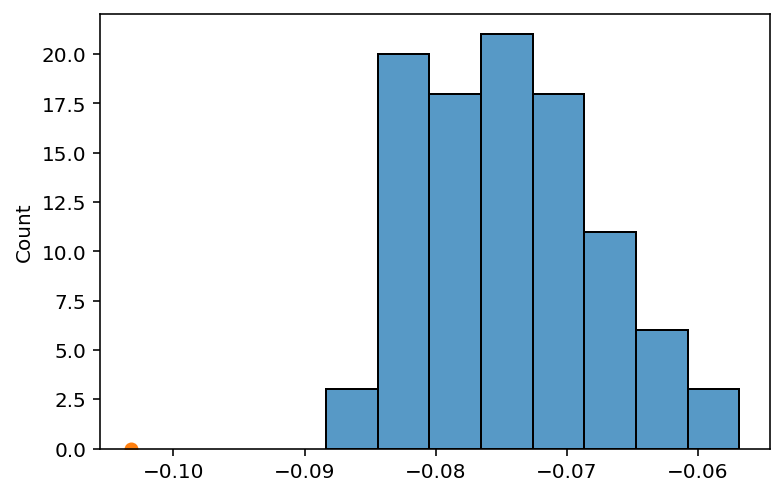

In [920]:
sns.histplot(precisions)
plt.scatter(observed, 0)

In [921]:
(precisions >= observed).mean()

1.0

In [917]:
def clean(stock_data):
    #All cleaning code from project 03
    res = requests.get('https://voteview.com/static/data/out/members/HSall_members.json').json()
    parties = pd.DataFrame(res)
    #gets representatives that are affiliated with either the democratic or republican party
    #dems_and_reps = parties[(parties['party_code'] == 100) | (parties['party_code'] == 200)]
    #Finds members of the 116th and 117th congresses, in order to merge with existing dataframe
    rel_members = parties[parties['congress'] >= 116]
    #find first and last name of congresspeople and join them together
    last = rel_members['bioname'].str.split().str[0].str[:-1].str.lower()
    first = rel_members['bioname'].str.split().str[1].str.lower()
    name = first + ' ' + last
    rel_members['full_name'] = name.str.replace(',', '')
    #new df that holds relevant members' names and party affiliation
    afilliation = rel_members.loc[:, {'party_code', 'full_name'}]
    #assigns all instances of "--" as NaN values
    for column in stock_data.columns:
        stock_data.loc[stock_data[column] == '--', column] = np.NaN
    #converts the disclosure_date column to datetime objects
    stock_data['disclosure_date'] = pd.to_datetime(stock_data['disclosure_date'])
    #converts the transaction_date column to datetime objects
    stock_data['transaction_date'] = pd.to_datetime(stock_data['transaction_date'], errors = 'coerce')
    #gets first and last name of representative and joins them together
    f = pd.Series(stock_data['representative'].str.strip().str.lower()).str.split().str[1]
    s = pd.Series(stock_data['representative'].str.strip().str.lower()).str.split().str[-1]
    n = f + ' ' + s
    stock_data['full_name'] = n
    #joins stock_data and affiliation to give representatives party affiliations
    stocks = pd.merge(stock_data, afilliation, how='left', on='full_name')
    stocks = stocks.rename(columns={'party_code':'Party Affiliation'})
    #Manually adds affiliation of representatives that were unsuccesful in the merge
    stats = [100.0, 100.0, 100.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0,200.0, 200.0, 200.0, 200.0, 200.0, 100.0, 100.0, 200.0, 200.0, 200.0, 100.0, 200.0,200.0, 100.0, 100.0, 100.0, 200.0, 200.0, 200.0, 200.0, 200.0]
    count = 0
    for i in stocks[stocks['Party Affiliation'].isna()]['full_name'].value_counts().index:
        stocks.loc[stocks[stocks.loc[:,'full_name'] == i].index, 'Party Affiliation'] = stats[count]
        count = count + 1
    #replaces party codes for party names
    stocks['Party Affiliation'] = stocks['Party Affiliation'].replace(100.0, 'democrat').replace(200.0, 'republican').replace(328, 'independent')
    #adds a month column
    stocks['month'] = pd.DatetimeIndex(stocks['transaction_date']).month
    #adds a 
    stocks = stocks.drop(stocks[stocks['Party Affiliation'] == 'independent'].index)
    stocks['amounts(lower estimate)'] = stocks['amount'].str.split().str[0].str[1:].str.replace(',','').astype(int)
    return stocks